In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (9,9)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
torch.manual_seed(0)
import scipy.signal as sp
from torch.utils.data import TensorDataset

![simpleresnet.png](simpleresnet.png)

This exercies uses a simple implementation of a deep neural network to explore the vanishing gradient problem

We have provided an example of a very simple feed forward network that has a strongly vanishing gradient w.r.t. the weights that are increasingly close to the input end. 

Your job is to modify the network so that it uses skip connections and make observations on what happens to the gradient after. 

Text(0, 0.5, 'Weight Gradients')

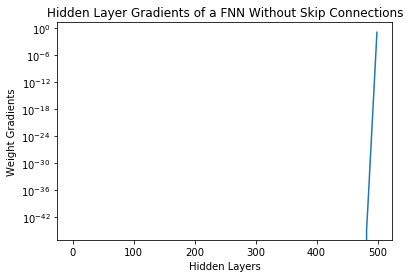

In [8]:
# Choose an activation function
activation = torch.sigmoid

# Choose a number of iterations
n = 500


# Store the feed-forward steps
w_list = []
z_list = []
a_list = []

# Make up some data
z_obs = torch.tensor([1.0])

# Initial value
x = torch.tensor([0.01])
z_prev = x

# Loop over a number of hidden layers
for i in range(n):
    # New weight
    w_i = torch.tensor([0.01],requires_grad=True)

    # Linear transform
    a_i = z_prev*w_i

    # Activation
    zprime_i = activation(a_i)

    #TODO: replace the line below with one that would add a skip connection
    z_i = zprime_i
    # Store forward model stuff
    w_list.append(w_i)
    z_list.append(z_prev)
 

    # output of layer i becomes input for layer i+1
    z_prev = z_i

# Objective function
L = torch.sqrt((z_i - z_obs)**2)

# Reverse-mode AD
L.backward()

# Print each weight's gradient
w_grad_init = []

#w_list.reverse()
for i in range(len(w_list)):
    grad = torch.abs(w_list[i].grad).tolist()[0]
    w_grad_init.append(grad)
    
plt.semilogy(w_grad_init)
plt.title('Hidden Layer Gradients of a FNN Without Skip Connections')
plt.xlabel('Hidden Layers')
plt.ylabel('Weight Gradients')

Text(0, 0.5, 'Weight Gradients')

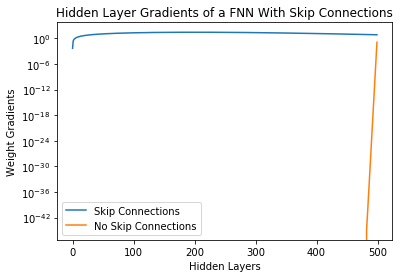

In [11]:
# Store the feed-forward steps
w_list = []
z_list = []
a_list = []

# Make up some data
z_obs = torch.randn((1,))
# Initial value
# Initial value
x = torch.tensor([0.01])
z_prev = x

# Loop over a number of hidden layers
for i in range(n):
    # New weight
    w_i = torch.tensor([0.01],requires_grad=True)

    # Linear transform
    a_i = z_prev*w_i

    # Activation
    zprime_i = activation(a_i)

    #TODO: replace the line below with one that would add a skip connection
    z_i = zprime_i + z_prev
    # Store forward model stuff
    w_list.append(w_i)
    z_list.append(z_prev)
 

    # output of layer i becomes input for layer i+1
    z_prev = z_i

# Objective function
L = torch.sqrt((z_i - z_obs)**2)

# Reverse-mode AD
L.backward()

# Print each weight's gradient
w_grad = []

#w_list.reverse()
for i in range(len(w_list)):
    grad = torch.abs(w_list[i].grad).tolist()[0]
    w_grad.append(grad)

#w_grad = sp.savgol_filter(w_grad,5,3)
plt.semilogy(w_grad,label='Skip Connections')
plt.semilogy(w_grad_init,label='No Skip Connections') #compare to previous network
plt.title('Hidden Layer Gradients of a FNN With Skip Connections')
plt.legend()
plt.xlabel('Hidden Layers')
plt.ylabel('Weight Gradients')


Now that we have seen how implementing skip connections seemingly solve the problem of vanishing gradients, we've learned all we can from the paper, lets look at some applications

------------

Below is a simple example of an image processing problem where vanishing gradient becomes an issue (no need to show it this time)

For training and testing data I generated random images for a training and test set. If the small problems are too easy feel free to increase the size of the datasets to make for more challenging problems

After you get done with the conceptual questions below, feel free to change the architecture of the below net. Make 3 changes to the architecture, record the loss difference after 100 iterations, and come up with a justification for that difference in loss

Now we will run an implemenation of a simple deep convolutional network on MNIST (handwritten numbers)

In [12]:
train_dataset = dsets.MNIST(root='./data',
                           train=True,
                           transform=transforms.ToTensor(),
                           download=True)

train_data = train_dataset.data[::20].unsqueeze(1).float()
train_targets = train_dataset.targets[::20].unsqueeze(1)

test_dataset = dsets.MNIST(root='./data',
                           train=False,
                           transform=transforms.ToTensor())

test_data = test_dataset.data[::20].unsqueeze(1).float()
test_targets = test_dataset.targets[::20].unsqueeze(1)

training_data = TensorDataset(train_data,train_targets)
testing_data = TensorDataset(test_data,test_targets)

train_loader = torch.utils.data.DataLoader(dataset=training_data,
                                          batch_size=100,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=testing_data,
                                          batch_size=100,
                                          shuffle=False)



This model allows you to input a specified number of convolutional layers in your network.

In [13]:
# basic net class
class Net(nn.Module):
    def __init__(self, num_input_images, num_layers):
        
        # batch size is needed to configure 
        self.num_input_images = num_input_images
        self.num_layers = num_layers
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 1, 3, padding = 1)
        self.linearization2 = nn.Linear(5*26*26,10)
        self.convout = nn.Conv2d(1, 5, 3)
        self.linears = nn.ModuleList([nn.Linear(28,28)])
        self.linears.extend([nn.Linear(28, 28) for i in range(1, self.num_layers-1)])
        
    
    def forward(self, x):
        ### Hint, you can store the input x here
        zprev = x
        # convolution
        self.conv1(zprev)
        for i in range(1,self.num_layers-1): #loops over a set number of blocks conv to relu
            
            x = self.linears[i](zprev)
            zi = F.relu(x)
            zprev = zi
    
            
        x = self.convout(zi)
        # outputed images needed to be flattened for a linear layer
        x = x.view(self.num_input_images, 5*26*26)
        # find linear patterns in non-linear data
        x = self.linearization2(x)
        return x    


In [14]:
def train_model(epic, your_net):
        train_accuracy = []
        test_accuracy = []
        
        model = your_net
        model.to(device)

        criterion = torch.nn.CrossEntropyLoss() #since ive set this up as a classification problem with bins number of classes

        optimizer = torch.optim.Adam(model.parameters())

        epochs = epic
        # Loop over the data

        for epoch in range(epochs):
                model.train()
                # Loop over each subset of data

                correct = 0
                total = 0        

                for d,t in train_loader:
                        # Zero out the optimizer's gradient buffer
                        optimizer.zero_grad()
                        # Make a prediction based on the model
                        outputs = model(d)
                        # Compute the loss
                        loss = criterion(outputs,t[:,0])
                        # Use backpropagation to compute the derivative of the loss with respect to the parameters
                        loss.backward()
                        # Use the derivative information to update the parameters
                        optimizer.step()

                        
                        _, predicted = torch.max(outputs.data, 1)
                        correct += len(predicted[predicted==t[:,0]])
                        total += len(predicted.flatten())
                                
                correcttest = 0
                totaltest = 0        

                for d,t in test_loader:
                
                    outputs = model(d)
                    _, predicted = torch.max(outputs.data, 1)
                    correcttest += len(predicted[predicted==t[:,0]])
                    totaltest += len(predicted.flatten())
                
                if epoch%10==0:      
                        print(epoch,loss.item(), ' Train_Accuracy = ', correct/total*100,' Test_Accuracy = ', correcttest/totaltest*100)
                
                train_accuracy.append(correct/total*100)
                test_accuracy.append(correcttest/totaltest*100)
        
        return train_accuracy, test_accuracy

You can mess with these paramenters and see how your model performance changes

In [15]:
num_input_images = 100
num_classes = 10
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
num_epochs = 50 #how long to run the model
num_layers = 35 #how many convolutions to perform

0 2.3328447341918945  Train_Accuracy =  9.433333333333334  Test_Accuracy =  9.0
10 2.3025357723236084  Train_Accuracy =  10.633333333333333  Test_Accuracy =  9.0
20 2.298368453979492  Train_Accuracy =  10.833333333333334  Test_Accuracy =  10.8
30 2.302497625350952  Train_Accuracy =  11.1  Test_Accuracy =  10.8
40 2.299931526184082  Train_Accuracy =  11.0  Test_Accuracy =  11.799999999999999


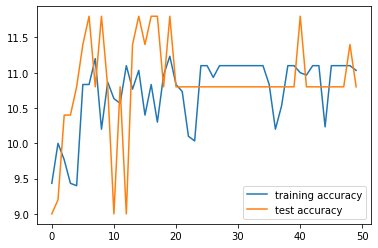

In [16]:
trainacc_init, testacc_init = train_model(num_epochs, Net(num_input_images, num_layers)) #train the model for a hundred epochs

plt.plot(trainacc_init, label = 'training accuracy')
plt.plot(testacc_init, label = 'test accuracy')
plt.legend()
plt.show()

In a similar fashion to what you did on the previous FNN, add skip connects and see if you can improve the model.

In [21]:
# basic net class

class ResNet(nn.Module):
    def __init__(self, num_input_images, num_layers):
        
        # batch size is needed to configure 
        self.num_input_images = num_input_images
        self.num_layers = num_layers
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 1, 3, padding = 1)
        #self.linearization1 = nn.Linear(28,28)
        self.linearization2 = nn.Linear(5*26*26,10)
        self.convout = nn.Conv2d(1, 5, 3)
        self.linears = nn.ModuleList([nn.Linear(28,28)])
        self.linears.extend([nn.Linear(28, 28) for i in range(1, self.num_layers-1)])
        
        self.a_list = []
        self.z_list = []
    
    def forward(self, x):
        ### Hint, you can store the input x here
        zprev = x
        # convolution
        self.conv1(zprev)
        for i in range(1,self.num_layers-1): #loops over a set number of blocks conv to relu
            
            #ai = self.linearization(zprev)
          
            ai = self.linears[i](zprev)
            
            # TODO: Implement skip connections in a similar fashion to what was done previously.
            # Think carefully about your skip intervals, and what should be used where
            # hint: use the lists defined as a class object, the modulus operator, and the .add() method
           
            zi = F.relu(ai)
            zi = zi.add(zprev)
            zprev = zi
            self.z_list.append(zi)
            self.a_list.append(ai)
            
            
        x = self.convout(zi)
        # outputed images needed to be flattened for a linear layer
        x = x.view(self.num_input_images, 5*26*26)
        # find linear patterns in non-linear data
        x = self.linearization2(x)
        return x    


0 3180.608642578125  Train_Accuracy =  19.466666666666665  Test_Accuracy =  21.8
10 32.8031120300293  Train_Accuracy =  52.63333333333333  Test_Accuracy =  54.2
20 12.665569305419922  Train_Accuracy =  72.8  Test_Accuracy =  70.19999999999999
30 6.534836292266846  Train_Accuracy =  80.16666666666666  Test_Accuracy =  75.0
40 3.743208646774292  Train_Accuracy =  84.63333333333334  Test_Accuracy =  75.2


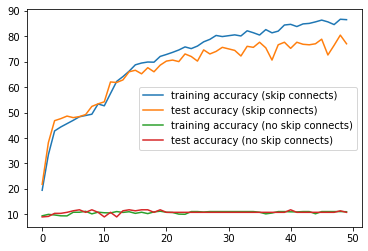

In [22]:
trainacc, testacc = train_model(num_epochs, ResNet(num_input_images, num_layers)) #train the model for a hundred epochs

plt.plot(trainacc, label = 'training accuracy (skip connects)')
plt.plot(testacc, label = 'test accuracy (skip connects)')
plt.plot(trainacc_init, label = 'training accuracy (no skip connects)')
plt.plot(testacc_init, label = 'test accuracy (no skip connects)')
plt.legend()
plt.show()

**Questions**

1. What is the vanishing gradient problem, and what is its primary cause?

2. What are 4 limitations to optimizing a deep convolutional neural network?

3. In terms of how a given block of a network is "fitted", what is the key difference between using skip connections and traditional blocks?

4. In the context of model hyper-parameters, what additional parameters is added in the res-net implementation?

5. How do skip connections resolve the "vanishing gradient" problem? (Open Ended)

6. Give an appropriate anology for how kernels are used to extract features from images (i.e. sanding wood)

7. Was this a good paper when it was released? Is it a good paper now? What has changed between now and it's initial release point? What other methods are there of solving the vanishing gradient problem? (Open Ended)

8. What interval of skip connections did you use and where were they applied to? Did you find any #accuracygainz ?

1) The vanishing gradient problem is when the gradients at each node in a computational graph are very small, meaning their product shrinks exponentially when the gradients are chained together during backpropagation. This problem is caused when an activation function such as a sigmoid forces a large input value to an output bound between two much smaller numbers (such as zero and one). When this occurs in many consecutive nodes, the product of the small gradients causes the gradient to rapidly approach zero, meaning network parameters won't be updated.

2) 1. The vanishing graident. As mentioned above, if there are many layers in a network, this increases the number of places where small gradients are possible, which increases the chances of a vanishing gradient.
2. Overfitting. If there are more layers in a network, there is more capacity to learn patterns from your inputs. If the network is sufficiently deep, this could lead to overfitting w.r.t. the input features.
3. Computational Cost. The more layers that are added to the network, the more the computational cost increases. 
4. Addition of residual layer when network changes size/depth. As discussed in the paper, there are a few methods for dealing with size changes when using a residual network. Some methods improve accuracy but are more computationally demanding, while others degrade accuracy but don't significantly alter optimization speed. 

3) In a traditional network, the output of any given layer is used as the input for the subsequent layer. When using skip connections however, the output of a layer is added to the output of an even older layer to use as an input to the next layer in the network. 

4) The key additional hyper-parameter of res-net is the number of layers to skip with the skip connection. In the resnet paper, their model skips every two layers, however in this exercise, implementing the skip connection at every layer caused notable improvement.

5) In a normal neural network that uses tanh activation functions and has all weights initialized to 0.001, if a layer received 1 as an input and passed it through its activation, it would return a value of 0.0009. Subsequent passes through the following layers would further decrease the size of this decimal. This is problematic, as the results of these layers are eventually chained together during backpropagation, which would lead to a very small gradient in even a relatively small network. However, if we were to use 1 as an input to the initial layer and then add it to 0.0009, we would get 1.0009 as the input for the next layer in the network. 1.0009 would then be multiplied by a weight, passed through the tanh activation, and added back to 1.0009.  As we move through the network, this number would remain relatively stable and close to 1, meaning the gradient would neither explode nor vanish during backpropagation. The process described above is exactly what resnet does with skip connections to solve the vanishing gradient problem. 

6) To use the sanding example, a freshly cut piece of wood will have a lot of blemishes and rough patches on its surface. However, if you were to sand the wood, you would remove these blemishes and reveal the underlying knots and rings that are truly representative of the structure of the tree. This is exactly what a kernel is doing when we run it over an image. It essentially removes the portions of the image that aren't important and highlights the portions of the image that we should focus on. 

7) I think the paper does a good job of introducting a solution to the vanishing gradient problem and showing that the proposed solution works. However, I think it is lacking in that they don't provide any details as to **why** their solution works. I feel like the why is a key component of scientific writing and is a good way to further back up that your methodology is sound. Clearly, based on the number of citations that this paper has, it contains useful information. However, a more robust discussion of why the method works would help bolster the author's claims. Other solutions to the vanishing gradient problem include normalizing the network inputs and performing normalization to intermediate layers in the network. 

8) I implemented skip connections between every layer for the entire network. As seen in the plot above, this architecture significantly improves accuracy in a network of 35 layers as compared to a model without the residual implementation. 